In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch as th
from typing import Dict
import torch
import torch.nn.functional as F
from pathlib import Path
import sys
sys.path.append(str(Path.cwd()))
import numpy as np

In [2]:
cd Diff-SCM-main

/Users/neha-mac/Documents/Diff-CF/Diff-SCM-main


In [ ]:
from diff_scm.datasets import loader

In [3]:
from diff_scm.datasets import loader
from diff_scm.configs import mnist_configs,brats_configs
from diff_scm.utils import dist_util
from diff_scm.sampling.sampling_utils import get_models_functions
from diff_scm.utils.script_util import get_models_from_config

/Users/neha-mac/opt/anaconda3/envs/diff/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
config = mnist_configs.get_default_configs()
dist_util.setup_dist()
print(f"device {dist_util.dev()}")
print(f"experiment folder {config.experiment_name}")
print(f"Counterfactual target class {config.sampling }")

device cpu
experiment folder exp_02_MNIST
Counterfactual target class batch_size: 100
classifier_path: ../experiment_data/exp_02_MNIST/classifier_train_class/model002999.pt
classifier_scale: 1.0
clip_denoised: true
counterfactual_class: 5
dynamic_sampling: true
eta: 0.0
image_conditional: false
label_of_intervention: y
model_path: ../experiment_data/exp_02_MNIST/score_train/model003000.pt
num_samples: 100
progress: false
reconstruction: true
sampling_progression_ratio: 0.75
target_class: 5
use_ddim: true



In [5]:
test_loader = loader.get_data_loader("mnist", config, split_set='test')

root-dir /Users/neha-mac/Documents/Diff-CF/Diff-SCM-main/remote/rds/groups/idcom_imaging/data/Brain/BRATS/MNIST


In [6]:
classifier, diffusion, model = get_models_from_config(config)

EncoderUNetModel(
  (time_embed): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): SiLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 32, eps=1e-05, affine=True)
          (1): Identity()
          (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=128, out_features=64, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 32, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0, inplace=False)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stri

In [ ]:
diffusion

In [7]:
cond_fn, model_fn, model_classifier_free_opt_fn, denoised_fn = get_models_functions(config, model, classifier)

In [32]:
data_dict = next(test_loader)

In [33]:
results_per_sample = {"original": ((data_dict['image'] + 1) * 127.5).clamp(0, 255).to(
    th.uint8)}
# send data points to GPU
model_kwargs = {k: v.to(dist_util.dev()) for k, v in data_dict.items()}
init_image = data_dict['image'].to(dist_util.dev())
# create counterfactual target 
model_kwargs["y"] = (config.sampling.counterfactual_class * th.ones((config.sampling.batch_size,))).to(th.long).to(dist_util.dev())

In [34]:
def get_input_data(config, data_dict):

    model_kwargs = {k: v.to(dist_util.dev()) for k, v in data_dict.items()}
    model_kwargs["y"] = (config.sampling.target_class * torch.ones((config.sampling.batch_size,))).to(torch.long).to(dist_util.dev())
    
    init_image = data_dict['image'].to(dist_util.dev())

    return model_kwargs,init_image

In [89]:
def est_counterfactual(config, diffusion, cond_fn, model_fn, model_classifier_free_fn, denoised_fn, data_dict):
    model_kwargs, init_image = get_input_data(config, data_dict)
    # DDIM loop in reverse time order for inferring exogenous noise (image latent space)    
    exogenous_noise, abduction_progression = diffusion.ddim_sample_loop(
            model_fn,
            (config.sampling.batch_size,
                config.score_model.num_input_channels,
                config.score_model.image_size,
                config.score_model.image_size),
            clip_denoised=config.sampling.clip_denoised,
            model_kwargs=model_kwargs,
            denoised_fn = None,
            noise=init_image,
            cond_fn=None,
            device=dist_util.dev(),
            progress=config.sampling.progress,
            eta=config.sampling.eta,
            reconstruction=False,
            sampling_progression_ratio = config.sampling.sampling_progression_ratio
        )
    init_image = exogenous_noise
    # DDIM diffusion inference  with conditioning (intervention), starting from a latent image instead of random noise
    counterfactual_image, diffusion_progression = diffusion.ddim_sample_loop(
            model_classifier_free_fn if config.score_model.classifier_free_cond else model_fn,
            (config.sampling.batch_size,
                config.score_model.num_input_channels,
                config.score_model.image_size,
                config.score_model.image_size),
            clip_denoised=config.sampling.clip_denoised,
            model_kwargs=model_kwargs,
            denoised_fn = denoised_fn ,
            noise=init_image,
            cond_fn=cond_fn ,
            device=dist_util.dev(),
            progress=config.sampling.progress,
            eta=config.sampling.eta,
            reconstruction=True,
            sampling_progression_ratio = config.sampling.sampling_progression_ratio
        )
    sampling_progression = abduction_progression + diffusion_progression
    return counterfactual_image, sampling_progression, exogenous_noise


In [90]:
counterfactual_image, sampling_progression , exogenous_noise= est_counterfactual(config, 
                                                diffusion, cond_fn, model_fn, 
                                                model_classifier_free_opt_fn, denoised_fn, 
                                                data_dict)

100%|██████████| 75/75 [01:13<00:00,  1.01it/s]


In [96]:
# test_set = counterfactual_image
test_set = exogenous_noise

In [97]:
counterfactual = ((test_set + 1) * 127.5).clamp(0, 255).to(th.uint8)
results_per_sample["counterfactual"] = counterfactual.cpu().numpy()


In [98]:
data_dict["image"].shape

torch.Size([100, 1, 28, 28])

In [99]:
sample_list = np.stack([v[:,0] for (k,v) in results_per_sample.items()])
sample_list = np.einsum("ibwh -> bihw",sample_list)
sample_list = sample_list[:16]
grid = np.concatenate(np.concatenate(sample_list,axis = 2),axis = 0)

(-0.5, 447.5, 55.5, -0.5)

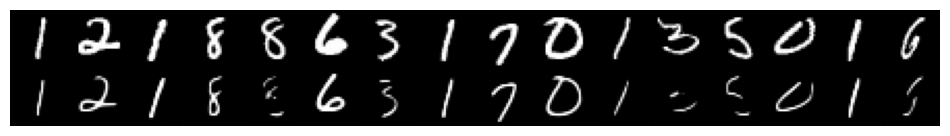

In [100]:
fig = plt.figure(figsize=(12.,40.))
plt.imshow(grid,cmap = 'gray')
plt.axis("off")